# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [17]:
import time

# Load Things

In [3]:
trainX_first = np.load('outputs/new_splitted/train_x_first.npy')
trainY_first = np.load('outputs/new_splitted/train_y_first.npy')

trainX_second = np.load('outputs/new_splitted/train_x_second.npy')
trainY_second = np.load('outputs/new_splitted/train_y_second.npy')

In [4]:
df_first = pd.read_csv('outputs/new_splitted/firsthalf.csv')
df_second = pd.read_csv('outputs/new_splitted/secondhalf.csv')

In [5]:
total_samples_first = trainX_first.shape[0]
split_index_first = int(total_samples_first * 0.9)

total_samples_second = trainX_second.shape[0]
split_index_second = int(total_samples_second * 0.9)

In [6]:
n_future = 1   # Number of data we want to look into the future based on the past data.
n_past = 24  # Number of past data we want to use to predict the future.

In [7]:
true_value_first = df_first['traffic_volume'][split_index_first+n_past:].values
true_value_second = df_second['traffic_volume'][split_index_second+n_past:].values

In [29]:
import joblib
scaler_first = joblib.load('outputs/new_splitted/MM_scaler_first.joblib')
scaler_second = joblib.load('outputs/new_splitted/MM_scaler_second.joblib')

In [31]:
df_first_preps = pd.read_csv('outputs/new_splitted/firsthalf_preps.csv')
df_second_preps = pd.read_csv('outputs/new_splitted/secondhalf_preps.csv')

In [30]:
df_first_preps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16193 entries, 0 to 16192
Data columns (total 65 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            16193 non-null  int64  
 1   air_pollution_index                                   16193 non-null  float64
 2   humidity                                              16193 non-null  float64
 3   wind_speed                                            16193 non-null  float64
 4   wind_direction                                        16193 non-null  float64
 5   visibility_in_miles                                   16193 non-null  float64
 6   dew_point                                             16193 non-null  float64
 7   temperature                                           16193 non-null  float64
 8   rain_p_h                                              16

# Train test Split

In [9]:
total_samples_first = trainX_first.shape[0]
split_index_first = int(total_samples_first * 0.9)

X_train_first = trainX_first[:split_index_first]
y_train_first = trainY_first[:split_index_first]
X_test_first = trainX_first[split_index_first:]
y_test_first = trainY_first[split_index_first:]

In [10]:
total_samples_second = trainX_second.shape[0]
split_index_second = int(total_samples_second * 0.9)

X_train_second = trainX_second[:split_index_second]
y_train_second = trainY_second[:split_index_second]
X_test_second = trainX_second[split_index_second:]
y_test_second = trainY_second[split_index_second:]

In [11]:
print(f'X_train_first length == {len(X_train_first)}')
print(f'X_test_first length == {len(X_test_first)}')

print(f'X_train_second length == {len(X_train_second)}')
print(f'X_test_second length == {len(X_test_second)}')

X_train_first length == 14552
X_test_first length == 1617
X_train_second length == 15231
X_test_second length == 1693


# Modelling

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM, Bidirectional, GRU

In [14]:
from kerastuner.tuners import RandomSearch

C:\Users\Naufal\AppData\Local\Temp\ipykernel_15192\2610907151.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# LSTM

## First Half Dataset

In [12]:
def build_model_LSTM_first(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(trainX_first.shape[1], trainX_first.shape[2]),
                   return_sequences=True))
    model.add(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_first.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [15]:
tuner_LSTM = RandomSearch(
    build_model_LSTM_first,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/LSTM_first/',
    project_name='LSTM_tuning_first'
)

tuner_LSTM.search(X_train_first, y_train_first, epochs=10, validation_data=(X_test_first, y_test_first))

Reloading Tuner from model/LSTM_first/LSTM_tuning_first\tuner0.json


In [16]:
# Get the optimal hyperparameters
best_hps_LSTM_first = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_LSTM_first.values:
    print(param, best_hps_LSTM_first.get(param))

units_layer1 64
activation tanh
units_layer2 64
dropout 0.2
optimizer rmsprop


In [20]:
# Build the model with the best hyperparameters
model_LSTM_tuned_first = tuner_LSTM.hypermodel.build(best_hps_LSTM_first)
start_time = time.time()
history_LSTM_tuned_first = model_LSTM_tuned_first.fit(trainX_first, trainY_first, epochs=50, validation_data=(X_test_first, y_test_first))
end_time = time.time()
training_time_LSTM_tuned_first = end_time - start_time

Epoch 1/50
506/506 [==============================] - 15s 18ms/step - loss: 0.1357 - val_loss: 0.1066
Epoch 2/50
506/506 [==============================] - 8s 15ms/step - loss: 0.0914 - val_loss: 0.1284
Epoch 3/50
506/506 [==============================] - 8s 15ms/step - loss: 0.0759 - val_loss: 0.0773
Epoch 4/50
506/506 [==============================] - 8s 15ms/step - loss: 0.0648 - val_loss: 0.0607
Epoch 5/50
506/506 [==============================] - 8s 15ms/step - loss: 0.0584 - val_loss: 0.0504
Epoch 6/50
506/506 [==============================] - 8s 16ms/step - loss: 0.0544 - val_loss: 0.0605
Epoch 7/50
506/506 [==============================] - 8s 16ms/step - loss: 0.0515 - val_loss: 0.0380
Epoch 8/50
506/506 [==============================] - 8s 15ms/step - loss: 0.0495 - val_loss: 0.0446
Epoch 9/50
506/506 [==============================] - 8s 16ms/step - loss: 0.0482 - val_loss: 0.0389
Epoch 10/50
506/506 [==============================] - 7s 15ms/step - loss: 0.0468 - val_l

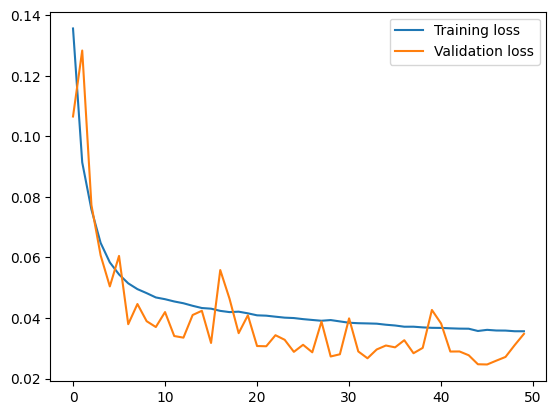

In [21]:
plt.plot(history_LSTM_tuned_first.history['loss'], label='Training loss')
plt.plot(history_LSTM_tuned_first.history['val_loss'], label='Validation loss')
plt.legend()

In [22]:
pred_LSTM_tuned_first = model_LSTM_tuned_first.predict(X_test_first)

51/51 [==============================] - 1s 6ms/step


In [51]:
prediction_copies = np.repeat(pred_LSTM_tuned_first, trainX_first.shape[2], axis=-1)
pred_LSTM_tuned_unscaled_first = scaler_first.inverse_transform(prediction_copies)[:,-1]

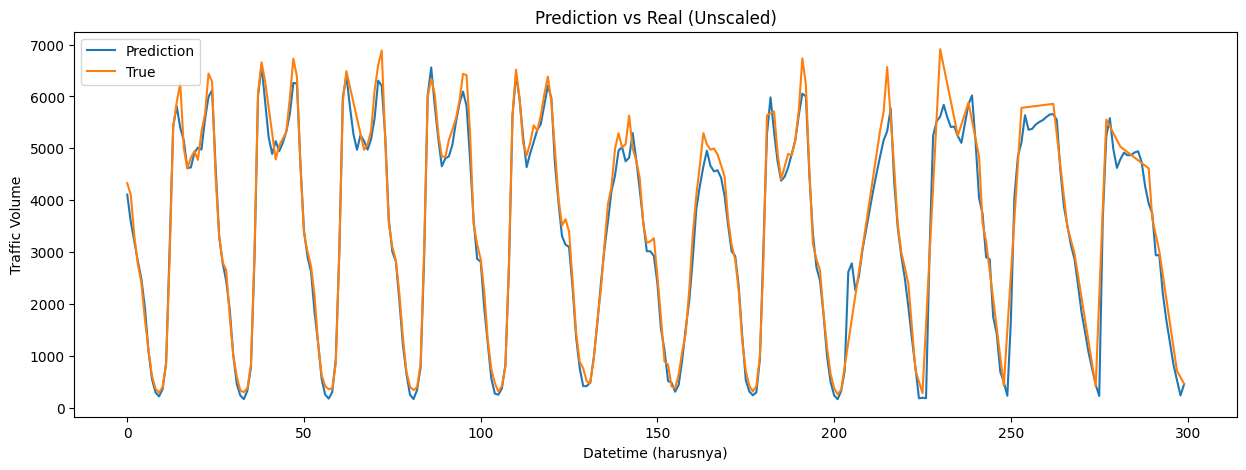

In [52]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_LSTM_tuned_unscaled_first[:300])
plt.plot(true_value_first[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [53]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import math


mae_LSTM = mean_absolute_error(pred_LSTM_tuned_unscaled_first, true_value_first)
rmse_LSTM = math.sqrt(mean_squared_error(pred_LSTM_tuned_unscaled_first, true_value_first))
mape_LSTM = mean_absolute_percentage_error(pred_LSTM_tuned_unscaled_first, true_value_first)

print(f'MAE : {mae_LSTM}')
print(f'RMSE: {rmse_LSTM}')
print(f'MAPE: {mape_LSTM}')
print(f'Time: {training_time_LSTM_tuned_first}')

MAE : 246.48670246410657
RMSE: 327.5533132828187
MAPE: 0.15099576232702003
Time: 397.55406665802


## Second Half Dataset

In [35]:
def build_model_LSTM_second(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(trainX_second.shape[1], trainX_second.shape[2]),
                   return_sequences=True))
    model.add(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_second.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [40]:
(trainX_second.shape[1], trainX_second.shape[2])

(24, 60)

In [36]:
tuner_LSTM_second = RandomSearch(
    build_model_LSTM_second,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/LSTM_second/',
    project_name='LSTM_tuning_second'
)

tuner_LSTM_second.search(X_train_second, y_train_second, epochs=10, validation_data=(X_test_second, y_test_second))

Reloading Tuner from model/LSTM_second/LSTM_tuning_second\tuner0.json


In [41]:
# Get the optimal hyperparameters
best_hps_LSTM_second = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_LSTM_second.values:
    print(param, best_hps_LSTM_second.get(param))

units_layer1 64
activation tanh
units_layer2 64
dropout 0.2
optimizer rmsprop


In [45]:
# Build the model with the best hyperparameters
model_LSTM_tuned_second = tuner_LSTM_second.hypermodel.build(best_hps_LSTM_second)
start_time = time.time()
history_LSTM_tuned_second = model_LSTM_tuned_second.fit(trainX_second, trainY_second, epochs=50, validation_data=(X_test_second, y_test_second))
end_time = time.time()
training_time_LSTM_tuned_second = end_time - start_time

Epoch 1/50
529/529 [==============================] - 16s 18ms/step - loss: 0.1301 - val_loss: 0.0813
Epoch 2/50
529/529 [==============================] - 8s 16ms/step - loss: 0.0888 - val_loss: 0.0722
Epoch 3/50
529/529 [==============================] - 8s 16ms/step - loss: 0.0744 - val_loss: 0.0549
Epoch 4/50
529/529 [==============================] - 9s 17ms/step - loss: 0.0632 - val_loss: 0.0525
Epoch 5/50
529/529 [==============================] - 9s 16ms/step - loss: 0.0560 - val_loss: 0.0405
Epoch 6/50
529/529 [==============================] - 8s 16ms/step - loss: 0.0517 - val_loss: 0.0410
Epoch 7/50
529/529 [==============================] - 9s 17ms/step - loss: 0.0497 - val_loss: 0.0344
Epoch 8/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0476 - val_loss: 0.0371
Epoch 9/50
529/529 [==============================] - 8s 16ms/step - loss: 0.0465 - val_loss: 0.0323
Epoch 10/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0454 - val_l

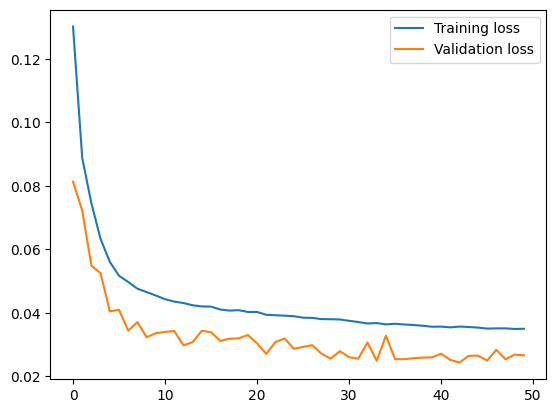

In [46]:
plt.plot(history_LSTM_tuned_second.history['loss'], label='Training loss')
plt.plot(history_LSTM_tuned_second.history['val_loss'], label='Validation loss')
plt.legend()

In [47]:
pred_LSTM_tuned_second = model_LSTM_tuned_second.predict(X_test_second)

53/53 [==============================] - 1s 6ms/step


In [54]:
prediction_copies = np.repeat(pred_LSTM_tuned_second, trainX_second.shape[2], axis=-1)
pred_LSTM_tuned_unscaled_second = scaler_second.inverse_transform(prediction_copies)[:,-1]

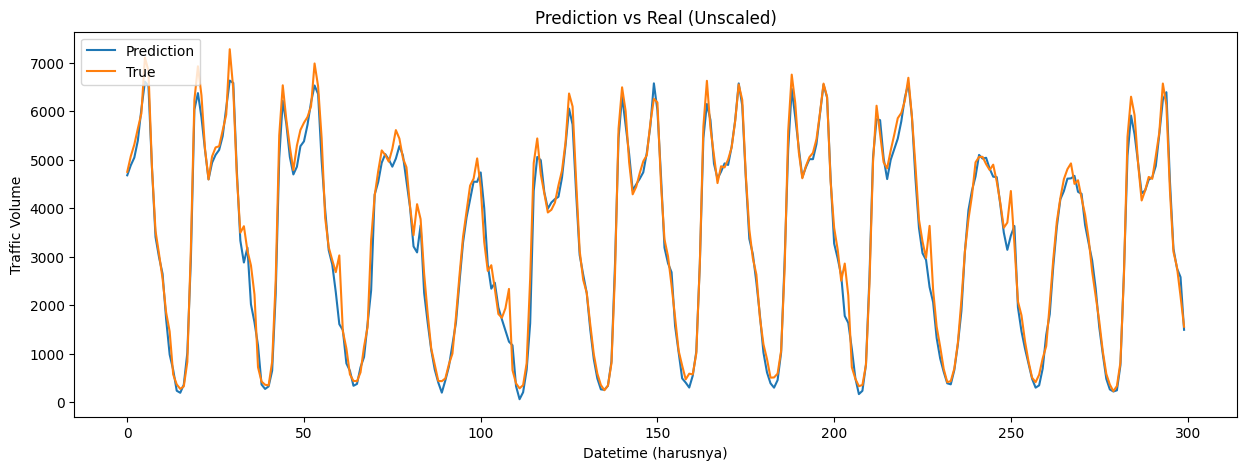

In [55]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_LSTM_tuned_unscaled_second[:300])
plt.plot(true_value_second[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

## Comparison

In [57]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import math


mae_LSTM_first = mean_absolute_error(pred_LSTM_tuned_unscaled_first, true_value_first)
rmse_LSTM_first = math.sqrt(mean_squared_error(pred_LSTM_tuned_unscaled_first, true_value_first))
mape_LSTM_first = mean_absolute_percentage_error(pred_LSTM_tuned_unscaled_first, true_value_first)

print(f'MAE  first: {mae_LSTM_first}')
print(f'RMSE first: {rmse_LSTM_first}')
print(f'MAPE first: {mape_LSTM_first}')
print(f'Time first: {training_time_LSTM_tuned_first}')

mae_LSTM_second = mean_absolute_error(pred_LSTM_tuned_unscaled_second, true_value_second)
rmse_LSTM_second = math.sqrt(mean_squared_error(pred_LSTM_tuned_unscaled_second, true_value_second))
mape_LSTM_second = mean_absolute_percentage_error(pred_LSTM_tuned_unscaled_second, true_value_second)

print(f'MAE  second: {mae_LSTM_second}')
print(f'RMSE second: {rmse_LSTM_second}')
print(f'MAPE second: {mape_LSTM_second}')
print(f'Time second: {training_time_LSTM_tuned_second}')

MAE  first: 246.48670246410657
RMSE first: 327.5533132828187
MAPE first: 0.15099576232702003
Time first: 397.55406665802
MAE  second: 193.8012598491743
RMSE second: 292.1269448497487
MAPE second: 0.11875556773890716
Time second: 422.28794598579407


# BiLSTM

## First Half Dataset

In [58]:
from kerastuner.tuners import RandomSearch

def build_model_BiLSTM(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                                activation=hp.Choice('activation', values=['relu', 'tanh']),
                                input_shape=(trainX_first.shape[1], trainX_first.shape[2]),
                                return_sequences=True)))
    model.add(Bidirectional(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu')))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_first.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [59]:
tuner_BiLSTM = RandomSearch(
    build_model_BiLSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/BiLSTM_first',
    project_name='BiLSTM_tuning_first'
)

tuner_BiLSTM.search(X_train_first, y_train_first, epochs=10, validation_data=(X_test_first, y_test_first))

Reloading Tuner from model/BiLSTM_first\BiLSTM_tuning_first\tuner0.json


In [60]:
# Get the optimal hyperparameters
best_hps_BiLSTM_first = tuner_BiLSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_BiLSTM_first.values:
    print(param, best_hps_BiLSTM_first.get(param))

units_layer1 128
activation tanh
units_layer2 48
dropout 0.1
optimizer rmsprop


In [62]:
# Build the model with the best hyperparameters
model_BiLSTM_tuned_first = tuner_BiLSTM.hypermodel.build(best_hps_BiLSTM_first)
start_time = time.time()
history_BiLSTM_tuned_first = model_BiLSTM_tuned_first.fit(trainX_first, trainY_first, epochs=50, validation_data=(X_test_first, y_test_first))
end_time = time.time()
training_time_BiLSTM_tuned_first = end_time - start_time

Epoch 1/50
506/506 [==============================] - 31s 41ms/step - loss: 0.1103 - val_loss: 0.0870
Epoch 2/50
506/506 [==============================] - 22s 43ms/step - loss: 0.0712 - val_loss: 0.0612
Epoch 3/50
506/506 [==============================] - 21s 42ms/step - loss: 0.0583 - val_loss: 0.0651
Epoch 4/50
506/506 [==============================] - 21s 40ms/step - loss: 0.0525 - val_loss: 0.0655
Epoch 5/50
506/506 [==============================] - 21s 41ms/step - loss: 0.0488 - val_loss: 0.0426
Epoch 6/50
506/506 [==============================] - 19s 38ms/step - loss: 0.0468 - val_loss: 0.0441
Epoch 7/50
506/506 [==============================] - 18s 35ms/step - loss: 0.0449 - val_loss: 0.0369
Epoch 8/50
506/506 [==============================] - 18s 35ms/step - loss: 0.0438 - val_loss: 0.0386
Epoch 9/50
506/506 [==============================] - 18s 36ms/step - loss: 0.0423 - val_loss: 0.0393
Epoch 10/50
506/506 [==============================] - 18s 36ms/step - loss: 0.041

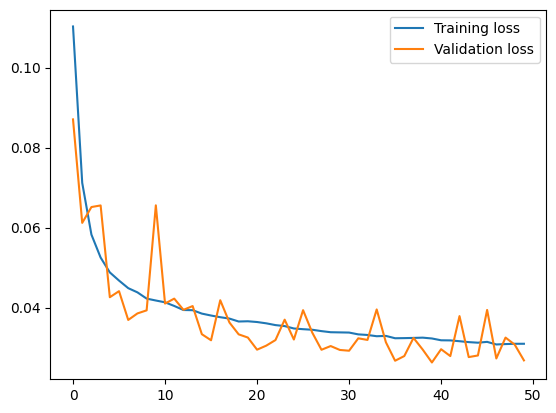

In [63]:
plt.plot(history_BiLSTM_tuned_first.history['loss'], label='Training loss')
plt.plot(history_BiLSTM_tuned_first.history['val_loss'], label='Validation loss')
plt.legend()

In [65]:
pred_BiLSTM_tuned_first = model_BiLSTM_tuned_first.predict(X_test_first)

51/51 [==============================] - 2s 14ms/step


In [66]:
prediction_copies = np.repeat(pred_BiLSTM_tuned_first, trainX_first.shape[2], axis=-1)
pred_BiLSTM_tuned_unscaled_first = scaler_first.inverse_transform(prediction_copies)[:,-1]

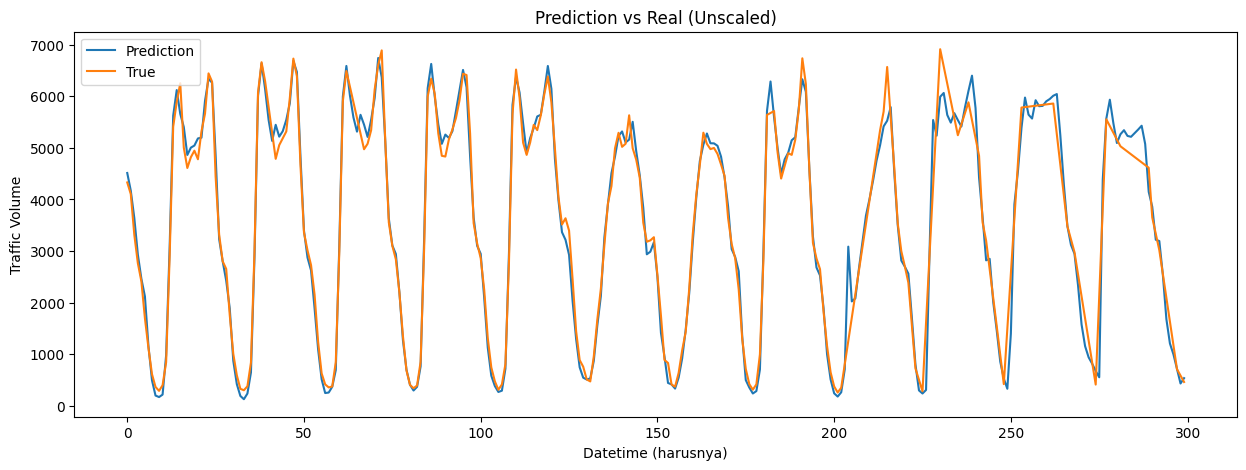

In [67]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_BiLSTM_tuned_unscaled_first[:300])
plt.plot(true_value_first[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

## Second Half Dataset

In [68]:
from kerastuner.tuners import RandomSearch

def build_model_BiLSTM_second(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                                activation=hp.Choice('activation', values=['relu', 'tanh']),
                                input_shape=(trainX_second.shape[1], trainX_second.shape[2]),
                                return_sequences=True)))
    model.add(Bidirectional(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu')))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_second.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [69]:
tuner_BiLSTM = RandomSearch(
    build_model_BiLSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/BiLSTM_second',
    project_name='BiLSTM_tuning_second'
)

tuner_BiLSTM.search(X_train_second, y_train_second, epochs=10, validation_data=(X_test_second, y_test_second))

Reloading Tuner from model/BiLSTM_second\BiLSTM_tuning_second\tuner0.json


In [70]:
# Get the optimal hyperparameters
best_hps_BiLSTM_second = tuner_BiLSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_BiLSTM_second.values:
    print(param, best_hps_BiLSTM_second.get(param))

units_layer1 32
activation tanh
units_layer2 48
dropout 0.1
optimizer adam


In [71]:
# Build the model with the best hyperparameters
model_BiLSTM_tuned_second = tuner_BiLSTM.hypermodel.build(best_hps_BiLSTM_second)
start_time = time.time()
history_BiLSTM_tuned_second = model_BiLSTM_tuned_second.fit(trainX_second, trainY_second, epochs=50, validation_data=(X_test_second, y_test_second))
end_time = time.time()
training_time_BiLSTM_tuned_second = end_time - start_time

Epoch 1/50
529/529 [==============================] - 22s 23ms/step - loss: 0.1046 - val_loss: 0.0693
Epoch 2/50
529/529 [==============================] - 9s 18ms/step - loss: 0.0639 - val_loss: 0.0527
Epoch 3/50
529/529 [==============================] - 10s 18ms/step - loss: 0.0540 - val_loss: 0.0525
Epoch 4/50
529/529 [==============================] - 10s 18ms/step - loss: 0.0483 - val_loss: 0.0368
Epoch 5/50
529/529 [==============================] - 10s 19ms/step - loss: 0.0449 - val_loss: 0.0336
Epoch 6/50
529/529 [==============================] - 10s 19ms/step - loss: 0.0426 - val_loss: 0.0337
Epoch 7/50
529/529 [==============================] - 8s 16ms/step - loss: 0.0409 - val_loss: 0.0339
Epoch 8/50
529/529 [==============================] - 9s 16ms/step - loss: 0.0396 - val_loss: 0.0319
Epoch 9/50
529/529 [==============================] - 9s 18ms/step - loss: 0.0387 - val_loss: 0.0358
Epoch 10/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0377 - 

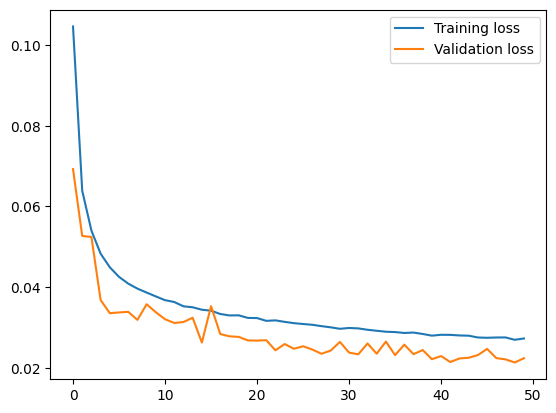

In [72]:
plt.plot(history_BiLSTM_tuned_second.history['loss'], label='Training loss')
plt.plot(history_BiLSTM_tuned_second.history['val_loss'], label='Validation loss')
plt.legend()

In [73]:
pred_BiLSTM_tuned_second = model_BiLSTM_tuned_second.predict(X_test_second)

53/53 [==============================] - 2s 8ms/step


In [74]:
prediction_copies = np.repeat(pred_BiLSTM_tuned_second, trainX_second.shape[2], axis=-1)
pred_BiLSTM_tuned_unscaled_second = scaler_second.inverse_transform(prediction_copies)[:,-1]

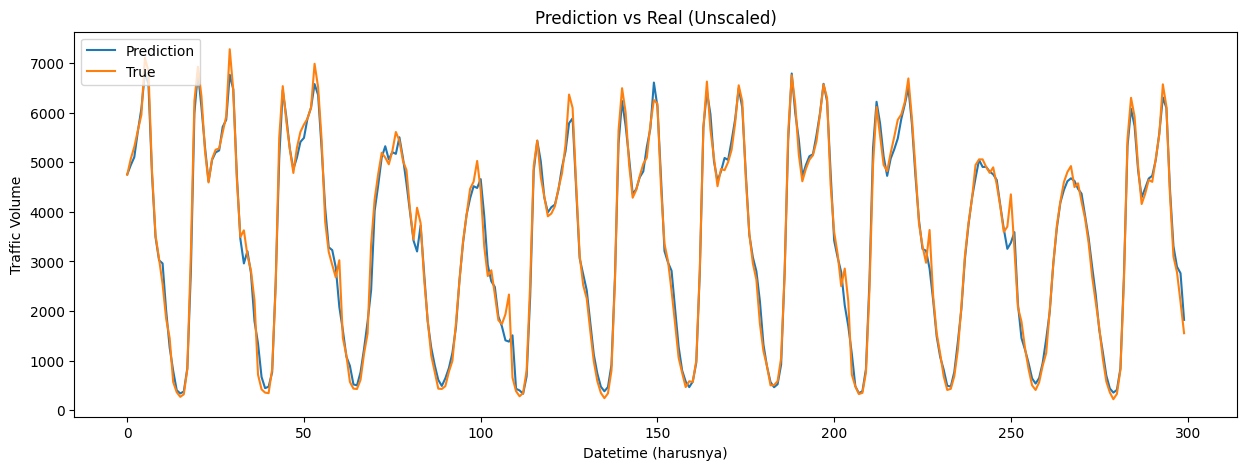

In [75]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_BiLSTM_tuned_unscaled_second[:300])
plt.plot(true_value_second[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

## Comparison

In [76]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import math


mae_BiLSTM_first = mean_absolute_error(pred_BiLSTM_tuned_unscaled_first, true_value_first)
rmse_BiLSTM_first = math.sqrt(mean_squared_error(pred_BiLSTM_tuned_unscaled_first, true_value_first))
mape_BiLSTM_first = mean_absolute_percentage_error(pred_BiLSTM_tuned_unscaled_first, true_value_first)

print(f'MAE  first: {mae_BiLSTM_first}')
print(f'RMSE first: {rmse_BiLSTM_first}')
print(f'MAPE first: {mape_BiLSTM_first}')
print(f'Time first: {training_time_BiLSTM_tuned_first}')

mae_BiLSTM_second = mean_absolute_error(pred_BiLSTM_tuned_unscaled_second, true_value_second)
rmse_BiLSTM_second = math.sqrt(mean_squared_error(pred_BiLSTM_tuned_unscaled_second, true_value_second))
mape_BiLSTM_second = mean_absolute_percentage_error(pred_BiLSTM_tuned_unscaled_second, true_value_second)

print(f'MAE  second: {mae_BiLSTM_second}')
print(f'RMSE second: {rmse_BiLSTM_second}')
print(f'MAPE second: {mape_BiLSTM_second}')
print(f'Time second: {training_time_BiLSTM_tuned_second}')

MAE  first: 190.18003415681565
RMSE first: 276.25426274539063
MAPE first: 0.11972613410735744
Time first: 1250.1419224739075
MAE  second: 163.1326025001269
RMSE second: 241.61706212912057
MAPE second: 0.08034506091007836
Time second: 501.2259533405304


# GRU

## First Half Dataset

In [77]:
def build_model_GRU_first(hp):
    model = Sequential()
    model.add(GRU(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(trainX_first.shape[1], trainX_first.shape[2]),
                   return_sequences=True))
    model.add(GRU(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_first.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [78]:
tuner_GRU = RandomSearch(
    build_model_GRU_first,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='/model/GRU_first',
    project_name='GRU_tuning_first'
)

tuner_GRU.search(X_train_first, y_train_first, epochs=10, validation_data=(X_test_first, y_test_first))

Reloading Tuner from /model/GRU_first\GRU_tuning_first\tuner0.json


In [79]:
# Get the optimal hyperparameters
best_hps_GRU_first = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_GRU_first.values:
    print(param, best_hps_GRU_first.get(param))

units_layer1 64
activation relu
units_layer2 64
dropout 0.5
optimizer adam


In [80]:
# Build the model with the best hyperparameters
model_GRU_tuned_first = tuner_GRU.hypermodel.build(best_hps_GRU_first)
start_time = time.time()
history_GRU_tuned_first = model_GRU_tuned_first.fit(trainX_first, trainY_first, epochs=50, validation_data=(X_test_first, y_test_first))
end_time = time.time()
training_time_GRU_tuned_first = end_time - start_time

Epoch 1/50
506/506 [==============================] - 12s 16ms/step - loss: 0.1294 - val_loss: 0.0602
Epoch 2/50
506/506 [==============================] - 8s 15ms/step - loss: 0.0848 - val_loss: 0.0453
Epoch 3/50
506/506 [==============================] - 8s 15ms/step - loss: 0.0762 - val_loss: 0.0431
Epoch 4/50
506/506 [==============================] - 7s 15ms/step - loss: 0.0705 - val_loss: 0.0472
Epoch 5/50
506/506 [==============================] - 8s 15ms/step - loss: 0.0696 - val_loss: 0.0447
Epoch 6/50
506/506 [==============================] - 8s 15ms/step - loss: 0.0668 - val_loss: 0.0397
Epoch 7/50
506/506 [==============================] - 7s 14ms/step - loss: 0.0662 - val_loss: 0.0476
Epoch 8/50
506/506 [==============================] - 7s 14ms/step - loss: 0.0647 - val_loss: 0.0423
Epoch 9/50
506/506 [==============================] - 7s 15ms/step - loss: 0.0642 - val_loss: 0.0402
Epoch 10/50
506/506 [==============================] - 8s 16ms/step - loss: 0.0634 - val_l

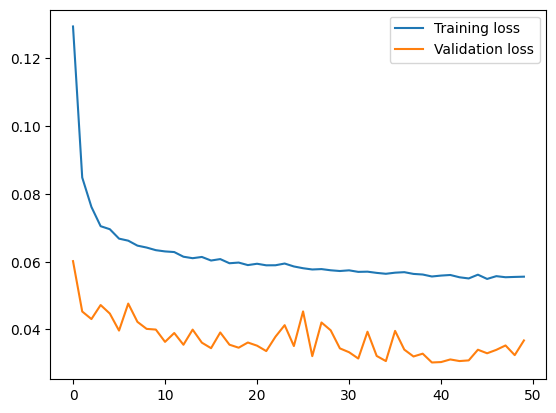

In [81]:
plt.plot(history_GRU_tuned_first.history['loss'], label='Training loss')
plt.plot(history_GRU_tuned_first.history['val_loss'], label='Validation loss')
plt.legend()

In [82]:
pred_GRU_tuned_first = model_GRU_tuned_first.predict(X_test_first)

51/51 [==============================] - 1s 5ms/step


In [83]:
prediction_copies = np.repeat(pred_GRU_tuned_first, trainX_first.shape[2], axis=-1)
pred_GRU_tuned_unscaled_first = scaler_first.inverse_transform(prediction_copies)[:,-1]

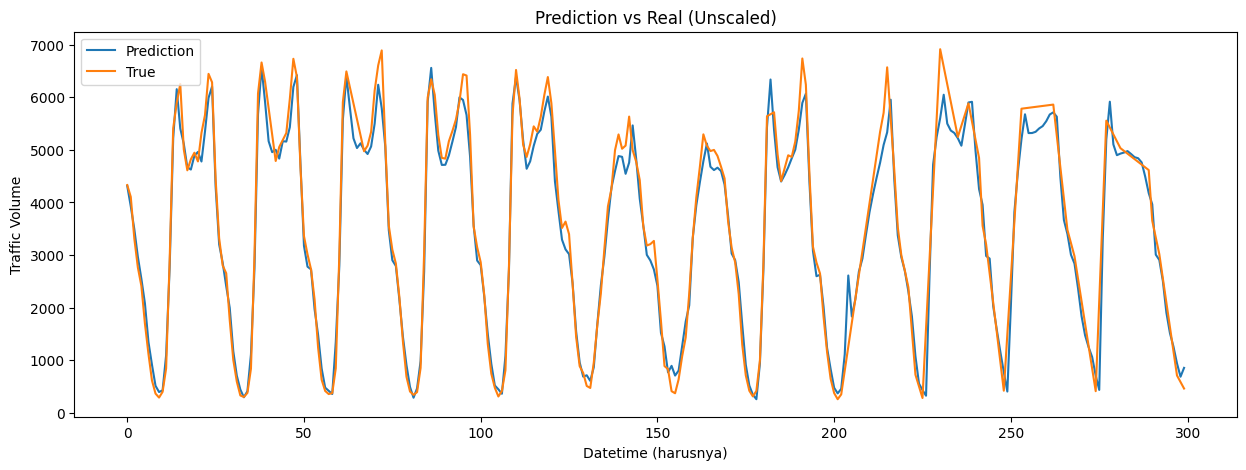

In [84]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_GRU_tuned_unscaled_first[:300])
plt.plot(true_value_first[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

## Second Half Dataset

In [85]:
def build_model_GRU_second(hp):
    model = Sequential()
    model.add(GRU(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(trainX_second.shape[1], trainX_second.shape[2]),
                   return_sequences=True))
    model.add(GRU(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_second.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [86]:
tuner_GRU_second = RandomSearch(
    build_model_GRU_second,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/GRU_second',
    project_name='GRU_tuning_second'
)

tuner_GRU_second.search(X_train_second, y_train_second, epochs=10, validation_data=(X_test_second, y_test_second))

Reloading Tuner from model/GRU_second\GRU_tuning_second\tuner0.json


In [87]:
# Get the optimal hyperparameters
best_hps_GRU_second = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_GRU_second.values:
    print(param, best_hps_GRU_second.get(param))

units_layer1 64
activation relu
units_layer2 64
dropout 0.5
optimizer adam


In [89]:
# Build the model with the best hyperparameters
model_GRU_tuned_second = tuner_GRU_second.hypermodel.build(best_hps_GRU_second)
start_time = time.time()
history_GRU_tuned_second = model_GRU_tuned_second.fit(trainX_second, trainY_second, epochs=50, validation_data=(X_test_second, y_test_second))
end_time = time.time()
training_time_GRU_tuned_second = end_time - start_time

Epoch 1/50
529/529 [==============================] - 12s 16ms/step - loss: 0.1312 - val_loss: 0.0790
Epoch 2/50
529/529 [==============================] - 8s 16ms/step - loss: 0.0821 - val_loss: 0.0497
Epoch 3/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0725 - val_loss: 0.0455
Epoch 4/50
529/529 [==============================] - 7s 14ms/step - loss: 0.0689 - val_loss: 0.0486
Epoch 5/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0656 - val_loss: 0.0436
Epoch 6/50
529/529 [==============================] - 8s 16ms/step - loss: 0.0640 - val_loss: 0.0398
Epoch 7/50
529/529 [==============================] - 8s 16ms/step - loss: 0.0634 - val_loss: 0.0421
Epoch 8/50
529/529 [==============================] - 7s 14ms/step - loss: 0.0619 - val_loss: 0.0372
Epoch 9/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0605 - val_loss: 0.0408
Epoch 10/50
529/529 [==============================] - 7s 14ms/step - loss: 0.0598 - val_l

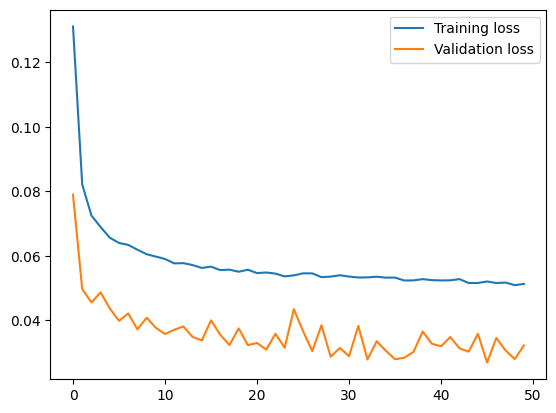

In [90]:
plt.plot(history_GRU_tuned_second.history['loss'], label='Training loss')
plt.plot(history_GRU_tuned_second.history['val_loss'], label='Validation loss')
plt.legend()

In [91]:
pred_GRU_tuned_second = model_GRU_tuned_second.predict(X_test_second)

53/53 [==============================] - 1s 5ms/step


In [92]:
prediction_copies = np.repeat(pred_GRU_tuned_second, trainX_second.shape[2], axis=-1)
pred_GRU_tuned_unscaled_second = scaler_second.inverse_transform(prediction_copies)[:,-1]

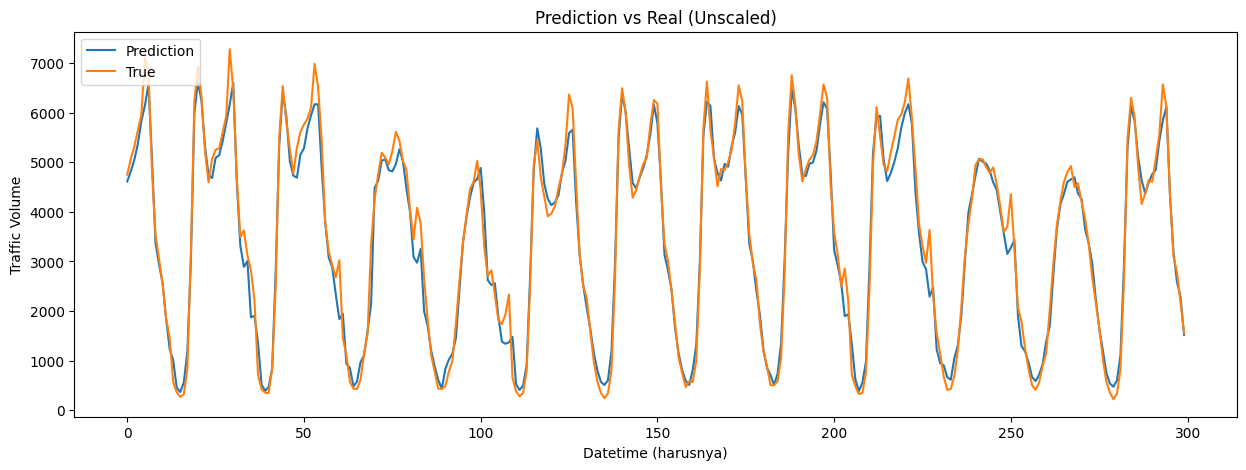

In [93]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_GRU_tuned_unscaled_second[:300])
plt.plot(true_value_second[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

## Comparison

In [95]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import math


mae_GRU_first = mean_absolute_error(pred_GRU_tuned_unscaled_first, true_value_first)
rmse_GRU_first = math.sqrt(mean_squared_error(pred_GRU_tuned_unscaled_first, true_value_first))
mape_GRU_first = mean_absolute_percentage_error(pred_GRU_tuned_unscaled_first, true_value_first)

print(f'MAE  first: {mae_GRU_first}')
print(f'RMSE first: {rmse_GRU_first}')
print(f'MAPE first: {mape_GRU_first}')
print(f'Time first: {training_time_GRU_tuned_first}')

mae_GRU_second = mean_absolute_error(pred_GRU_tuned_unscaled_second, true_value_second)
rmse_GRU_second = math.sqrt(mean_squared_error(pred_GRU_tuned_unscaled_second, true_value_second))
mape_GRU_second = mean_absolute_percentage_error(pred_GRU_tuned_unscaled_second, true_value_second)

print(f'MAE  second: {mae_GRU_second}')
print(f'RMSE second: {rmse_GRU_second}')
print(f'MAPE second: {mape_GRU_second}')
print(f'Time second: {training_time_GRU_tuned_second}')

MAE  first: 260.78717647312004
RMSE first: 351.5170394221301
MAPE first: 0.10694769188249888
Time first: 364.7588496208191
MAE  second: 234.24988262539281
RMSE second: 323.9308459724884
MAPE second: 0.11521024656506486
Time second: 390.8042175769806


# COMPARISON

In [96]:
data_LSTM_first = {'Model': 'LSTM_first', 'MAE': mae_LSTM_first, 'RMSE': rmse_LSTM_first, 'MAPE': mape_LSTM_first, 'Time': training_time_LSTM_tuned_first}
data_LSTM_second = {'Model': 'LSTM_second', 'MAE': mae_LSTM_second, 'RMSE': rmse_LSTM_second, 'MAPE': mape_LSTM_second, 'Time': training_time_LSTM_tuned_second}

data_BiLSTM_first = {'Model': 'BiLSTM_first', 'MAE': mae_BiLSTM_first, 'RMSE': rmse_BiLSTM_first, 'MAPE': mape_BiLSTM_first, 'Time': training_time_BiLSTM_tuned_first}
data_BiLSTM_second = {'Model': 'BiLSTM_second', 'MAE': mae_BiLSTM_second, 'RMSE': rmse_BiLSTM_second, 'MAPE': mape_BiLSTM_second, 'Time': training_time_BiLSTM_tuned_second}

data_GRU_first = {'Model': 'GRU_first', 'MAE': mae_GRU_first, 'RMSE': rmse_GRU_first, 'MAPE': mape_GRU_first, 'Time': training_time_GRU_tuned_first}
data_GRU_second = {'Model': 'GRU_second', 'MAE': mae_GRU_second, 'RMSE': rmse_GRU_second, 'MAPE': mape_GRU_second, 'Time': training_time_GRU_tuned_second}

df_metrics = pd.DataFrame([data_LSTM_first, data_LSTM_second, data_BiLSTM_first, data_BiLSTM_second, data_GRU_first, data_GRU_second, ])

In [97]:
df_metrics

,Model,MAE,RMSE,MAPE,Time
0,LSTM_first,246.486702,327.553313,0.150996,397.554067
1,LSTM_second,193.801260,292.126945,0.118756,422.287946
2,BiLSTM_first,190.180034,276.254263,0.119726,1250.141922
3,BiLSTM_second,163.132603,241.617062,0.080345,501.225953
4,GRU_first,260.787176,351.517039,0.106948,364.758850
5,GRU_second,234.249883,323.930846,0.115210,390.804218


In [99]:
# df_metrics.to_csv('outputs/new/metric_splitted_tuned.csv')

In [98]:
# model_LSTM_tuned_first.save('outputs/new_splitted/model/LSTM_tuned_first.h5')
# model_LSTM_tuned_second.save('outputs/new_splitted/model/LSTM_tuned_second.h5')
# model_BiLSTM_tuned_first.save('outputs/new_splitted/model/BiLSTM_tuned_first.h5')
# model_BiLSTM_tuned_second.save('outputs/new_splitted/model/BiLSTM_tuned_second.h5')
# model_GRU_tuned_first.save('outputs/new_splitted/model/GRU_tuned_first.h5')
# model_GRU_tuned_second.save('outputs/new_splitted/model/GRU_tuned_second.h5')

c:\Users\Naufal\anaconda3\envs\XAI\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
